## Benchmark for comparing speeds of retrieval of hyperplanes

We create different multidimensional arrays with different backends:
* Caterva
* zarr
* HDF5

In brief, each approach has its own strengths and weaknesses.

In [1]:
import os
import shutil
from time import time
import numpy as np

import cat4py as cat
import zarr
import numcodecs
import tables
import pandas as pd

In [2]:
from ipython_memwatcher import MemWatcher
mw = MemWatcher()
mw.start_watching_memory()

In [2] used 0.016 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 93.172 MiB


In [3]:
# Set this to True to benchmark the persistent storage for the backends
persistent = False

In [3] used 0.070 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 93.242 MiB


In [4]:
# Filenames for persistent storage
fname_cat = None
fname_zarr = None
fname_h5 = "in-memory.h5"
if persistent:
    fname_cat = "compare_getslice.cat"
    if os.path.exists(fname_cat):
        os.remove(fname_cat)
    fname_zarr = "compare_getslice.zarr"
    if os.path.exists(fname_zarr):
        shutil.rmtree(fname_zarr)
    fname_h5 = "compare_getslice.h5"
    if os.path.exists(fname_h5):
        os.remove(fname_h5)

In [4] used 0.055 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 93.297 MiB


In [5]:
dtype = np.float64

# Dimensions for the arrays
# 'Small' arrays config follows...
# shape = (100, 500, 250)
# pshape = (20, 500, 50)
shape = (100, 5000, 250)
pshape = (20, 500, 50)

# This config generates containers of more than 2 GB in size
# shape = (250, 4000, 350)
# pshape = (200, 100, 100)

# Compression properties
cname = "zstd"
clevel = 6
filter = cat.SHUFFLE
nthreads = 4

# Dicts for timers
wtimes = {}
rtimes = {}

# Dict for cratios
cratios = {}

In [5] used 0.039 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 93.336 MiB


In [6]:
# Create content for populating arrays
content = np.linspace(0, 10, int(np.prod(shape)), dtype=dtype).reshape(shape)

In [6] used 954.418 MiB RAM in 1.134s, peaked 0.000 MiB above current, total RAM usage 1047.754 MiB


In [7]:
t0 = time()
a = cat.empty(shape, pshape=pshape, itemsize=content.itemsize, filename=fname_cat,
              cname=cname, clevel=clevel, filters=[filter],
              cnthreads=nthreads, dnthreads=nthreads)
for block, info in a.iter_write():
    nparray = content[info.slice]
    block[:] = bytes(nparray)
acratio = a.cratio
t1 = time()
print("Time for filling array (caterva, iter): %.3fs ; CRatio: %.1fx" % ((t1 - t0), acratio))
wtimes['caterva'] = (t1 - t0)
cratios['caterva'] = acratio

Time for filling array (caterva, iter): 4.576s ; CRatio: 21.2x
In [7] used 76.516 MiB RAM in 4.581s, peaked 0.000 MiB above current, total RAM usage 1124.270 MiB


In [8]:
# Create and fill a zarr array
t0 = time()
compressor = numcodecs.Blosc(cname=cname, clevel=clevel, shuffle=filter)
numcodecs.blosc.set_nthreads(nthreads)
if persistent:
    z = zarr.open(fname_zarr, mode='w', shape=shape, chunks=pshape, dtype=dtype, compressor=compressor)
else:
    z = zarr.empty(shape=shape, chunks=pshape, dtype=dtype, compressor=compressor)
z[:] = content
t1 = time()
zcratio = z.nbytes / z.nbytes_stored
print("Time for filling array (zarr): %.3fs ; CRatio: %.1fx" % ((t1 - t0), zcratio))
wtimes['zarr'] = (t1 - t0)
cratios['zarr'] = zcratio

Time for filling array (zarr): 5.058s ; CRatio: 21.2x
In [8] used 75.930 MiB RAM in 5.065s, peaked 0.000 MiB above current, total RAM usage 1200.199 MiB


In [9]:
# Create and fill a hdf5 array
t0 = time()
filters = tables.Filters(complevel=clevel, complib="blosc:%s" % cname, shuffle=True)
tables.set_blosc_max_threads(nthreads)
if persistent:
    h5f = tables.open_file(fname_h5, 'w')
else:
    h5f = tables.open_file(fname_h5, 'w', driver='H5FD_CORE', driver_core_backing_store=0)
h5ca = h5f.create_carray(h5f.root, 'carray', filters=filters, chunkshape=pshape, obj=content)
h5f.flush()
t1 = time()
h5cratio = h5ca.size_in_memory / h5ca.size_on_disk
print("Time for filling array (hdf5): %.3fs ; CRatio: %.1fx" % ((t1 - t0), h5cratio))
wtimes['hdf5'] = (t1 - t0)
cratios['hdf5'] = h5cratio

Time for filling array (hdf5): 10.561s ; CRatio: 21.2x
In [9] used 51.621 MiB RAM in 10.567s, peaked 0.000 MiB above current, total RAM usage 1251.820 MiB


In [10]:
# Get the coordinates for random planes
planes_idx = np.random.randint(0, shape[1], 100)

In [10] used 0.023 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 1251.844 MiB


In [11]:
# Time getitem with caterva
t0 = time()
for i in planes_idx:
    rbytes = a[:,i,:]
    block = np.frombuffer(rbytes, dtype=dtype).reshape((shape[0], shape[2]))
t1 = time()
print("Time for reading with getitem (caterva): %.3fs" % (t1 - t0))
rtimes['caterva'] = (t1 - t0)

Time for reading with getitem (caterva): 4.062s
In [11] used 2.152 MiB RAM in 4.064s, peaked 0.000 MiB above current, total RAM usage 1253.996 MiB


In [12]:
# Time getitem with zarr
t0 = time()
for i in planes_idx:
    block = z[:,i,:]
t1 = time()
print("Time for reading with getitem (zarr): %.3fs" % (t1 - t0))
rtimes['zarr'] = (t1 - t0)

Time for reading with getitem (zarr): 5.184s
In [12] used 0.477 MiB RAM in 5.185s, peaked 0.000 MiB above current, total RAM usage 1254.473 MiB


In [13]:
# Time getitem with hdf5
t0 = time()
if persistent:
    h5f.close()
    h5f = tables.open_file(fname_h5, 'r', filters=filters)
h5ca = h5f.root.carray
for i in planes_idx:
    block = h5ca[:,i,:]
t1 = time()
print("Time for reading with getitem (hdf5): %.3fs" % (t1 - t0))
rtimes['hdf5'] = (t1 - t0)

Time for reading with getitem (hdf5): 7.803s
In [13] used -5.031 MiB RAM in 7.805s, peaked 6.113 MiB above current, total RAM usage 1249.441 MiB


In [14]:
# Release resources
del a
del z
h5f.close()

In [14] used -74.770 MiB RAM in 0.066s, peaked 74.801 MiB above current, total RAM usage 1174.672 MiB


In [15]:
wtimes,rtimes

({'caterva': 4.575556993484497,
  'zarr': 5.057929039001465,
  'hdf5': 10.56117296218872},
 {'caterva': 4.0619471073150635,
  'zarr': 5.183737754821777,
  'hdf5': 7.80312705039978})

In [15] used -0.621 MiB RAM in 0.021s, peaked 0.621 MiB above current, total RAM usage 1174.051 MiB


In [16]:
%matplotlib inline

In [16] used -4.156 MiB RAM in 0.148s, peaked 4.203 MiB above current, total RAM usage 1169.895 MiB


In [17]:
store = "on-disk" if persistent else "in-memory"
fontsize = 16

In [17] used 0.031 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 1169.926 MiB


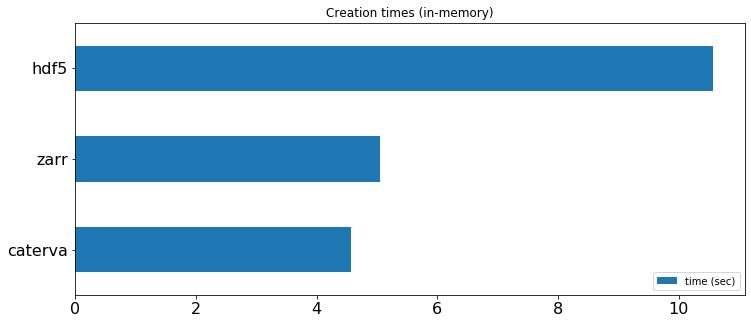

In [18] used -102.363 MiB RAM in 0.210s, peaked 102.383 MiB above current, total RAM usage 1067.562 MiB


In [18]:
# Creation times
labels = ["caterva", "zarr", "hdf5"]
df = pd.DataFrame({'time (sec)': [wtimes['caterva'], wtimes['zarr'], wtimes['hdf5']]}, index=labels)
df.plot(kind='barh', figsize=(12,5), color=None, fontsize=fontsize, title="Creation times (%s)" % store)

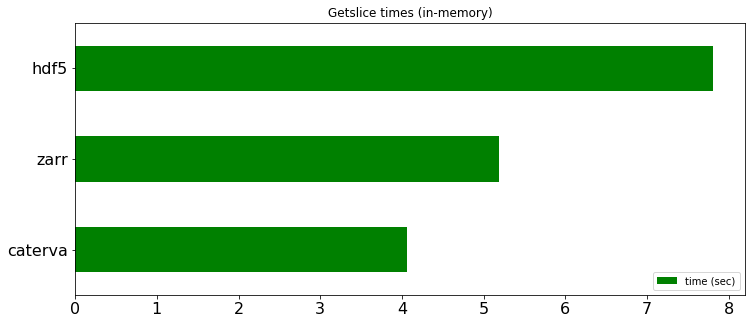

In [19] used 1.680 MiB RAM in 0.165s, peaked 0.000 MiB above current, total RAM usage 1069.242 MiB


In [19]:
# Getslice times
labels = ["caterva", "zarr", "hdf5"]
df = pd.DataFrame({'time (sec)': [rtimes['caterva'], rtimes['zarr'], rtimes['hdf5']]}, index=labels)
df.plot(kind='barh', figsize=(12,5), color="green", fontsize=fontsize, title="Getslice times (%s)" % store)

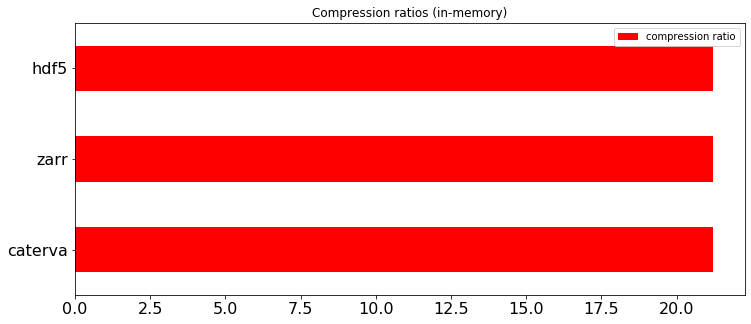

In [20] used 1.707 MiB RAM in 0.205s, peaked 0.000 MiB above current, total RAM usage 1070.949 MiB


In [20]:
# Compression ratios
labels = ["caterva", "zarr", "hdf5"]
df = pd.DataFrame({'compression ratio': [cratios['caterva'], cratios['zarr'], cratios['hdf5']]}, index=labels)
df.plot(kind='barh', figsize=(12,5), color="red", fontsize=fontsize, title="Compression ratios (%s)" % store)